# Projet Leyenda

## I. Introduction

### 1.1 Introduction au projet

L’entreprise TouNum fait appel à nos services afin d’ajouter à leurs prestations un algorithme de Machine Learning permettant d’améliorer les performances de numérisation de leurs clients. Le premier contrat concerne une solution visant à analyser des photographies afin d’en écrire une légende descriptive automatique, en suivant le concept de captioning.

Cette mission implique plusieurs enjeux : dans un premier temps, les images étant de qualité, définition et résolution pouvant être variables, il faudra nettoyer l’image. De plus, comme ceux-ci comptent travailler sur des types de documents différents, il sera important de savoir trier les documents en question.

![](https://i.ibb.co/jRY8m0y/workflow-projet.png)

Ci-dessus, le Workflow fournit par Tounum. Pour implémenter les algorithmes, nous utiliserons Python (sous forme d’un Notebook Jupyter) ainsi que les librairies SciKit et TensorFlow. D’un point de vue plus mathématique, nous utiliserons également NumPy et MatPlotLib.

Tounum nous fournit également un Dataset dans lequel des images déjà catégorisées permettront d’entraîner nos algorithmes. Dans un premier temps, nous effectuerons une classification binaire via un réseau de neurones afin de classer les fichiers en 2 classes : photos et autres images. Il faudra donc différencier les photos des schémas ainsi que des peintures par exemple.

Pour le captioning, 2 techniques de Machine Learning sont à utiliser. Dans un premier temps, les réseaux de neurones convolutifs, CNN, afin de prétraiter les images. Par la suite, des réseaux de neurones récurrents, RNN, pour générer les étiquettes (descriptions).

Une autre contrainte est à prendre en compte, notamment l’automatisation complète du processus, de l’insertion du jeu de données jusqu’à la création des étiquettes.

3 livrables seront à rendre respectivement fin de semaine 3, fin de semaine 4 et fin de semaine 5 :

- Livrable 1 : Classification Binaire.

- Livrable 2 : Traitement d’images.

- Livrable 3 : Captioning d’images.

Dans ce notebook, vous trouverez le code ainsi que les justifications techniques complètes concernant le livrable 2 sur le débruitage des images.


### 1.2 Notre équipe de Bordeaux

L'équipe est composé d'étudiants de CESI en option **Data Science** composée de :
- Elise Beaumatin
- Axel Brosset
- Gaylord Giret
- Xavier Labarbe
- Mathieu Musard

### 1.3 Introduction au livrable 2 : Débruitage des images

Lors de notre précédent livrable, nous avons établi un algorithme de classification binaire permettant d’identifier les photographies parmi un ensemble d’images. Via l’apprentissage d’un groupe de photos donné, nous avons obtenu une précision de **99%**. A la suite du livrable 1, nous récupérons donc un ensemble de photos, avec un taux d’erreur de 1%. Nous passons donc à la prochaine étape du traitement. 

Ce notebook nous permettra de présenter le travail effectué sur le livrable 2. L’objectif de ce livrable est de traiter des photographies afin d’améliorer leur efficacité et précision lors d’utilisation d’algorithmes de Machine Learning et Deep Learning.  

Pour ce faire nous développerons un algorithme qui débruitera les images via un auto-encodeur. Cela permettra d’améliorer la qualité des informations de nos photos, apporter une homogénéité de la précision sur toutes les images. On pourra ainsi faire un meilleur traitement.

## II. Importations des modules et des données

### 2.1 Importation des modules

La première chose à faire pour faire fonctionner ce notebook et espérer modéliser les données avec les dernières techniques de machine learning tout en exploitant la puissance de certaines librairies Python comme NumPy, TensorFlow et matplotlib, est d'installer et d'importer les librairies Python que nous allons utiliser dans ce notebook. Préalablement, il convient d'installer ces librairies dans notre environnement d'exécution avec les commandes **'!pip install'** ou **'!conda install'**, conformément aux instructions indiquées sur les sites de ces librairies. Une fois installées, nous pouvons importer les librairies dans le notebook. Vous pouvez trouver toutes les librairies que nous avons utilisées dans le bloc de code ci-dessous.

In [1]:
# --- Libraries for preparing and importing data --- # 

import os                          
from zipfile import ZipFile       
from PIL import Image              
import shutil                      
import glob    

# --- Libraries for creating AI model and for handling data --- # 

import tensorflow as tf            
import numpy as np                
from tensorflow import keras       
from keras import layers           
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2B0
from sklearn.model_selection import train_test_split
from keras import backend as K

# --- Libraries for plotting data --- # 

import plotly.express as px        
import matplotlib.pyplot as plt    
from keras.utils import plot_model

# --- Libraries for GPU usage --- # 

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

# --- Definition of colors code for Jupyter Notebooks (For printing purpose) --- #

yellow = '\033[93m'
green = '\033[92m'
red = '\033[91m'
default = '\033[39m'


# Creates a config object from the ConfigProto class
config = ConfigProto()

# Allows GPU memory growth
config.gpu_options.allow_growth = True

# Creates an interactive session with the specified config
session = InteractiveSession(config=config)

### 2.2 Récupération des données

Une fois que nous avons toutes nos librairies, nous allons devoir récupérer les données nécessaires à la réalisation du notebook. En science des données, il existe plusieurs moyens d'obtenir des données. Il est possible de s'appuyer sur des données locales (par exemple des fichiers plat sur notre machine), d'interroger des bases de données, d'interroger des API (Application Programming Interface), ou encore d'extraire des données depuis des sites Web. Dans notre cas le jeu de données est fourni par le CESI à l'URL suivant :   

https://cesifr-my.sharepoint.com/:u:/g/personal/cmeslin_cesi_fr/EZuPZuL19sdLv39Xjvs_S9sBUjUAz2jrRLg37hwctCybFQ?e=UQzPuc

Il s'agit d'une archive au format Zip qui contient un dossier avec toutes les images. Pour créer un jeu de données tensorflow à partir de ces images il va falloir extraire les images des archives.

Afin de préparer les images à leur utilisation par ce notebook, il faut créer un répertoire "Datasets" au même niveau que l'emplacement de ce notebook et y déposer les archives contenant les datasets uniquement étiquetés **Livrable 2**. Voir l'exemple sur l'image suivante. (**Attention ! Une archive doit contenir un ou plusieurs dossier contenant les images, les images ne doivent pas être à la racine de l'archive**)

![](https://i.ibb.co/xCvbyck/image.png)

### 2.3 Extraction des données

Maintenant que nous avons créé un répertoire avec l'archive qui contient les images, nous pouvons exécuter le code qui permettra d'extraire les images et les organiser dans un dossier.

In [2]:
# --- Definition of variables --- #

allow_extraction = False # Boolean : 'True' will extract the data and 'False' will prevent data from being extracted.
datasets_path = r"./Datasets" # String : Path to the folder containing the datasets (in ZIP format). 

extracted_datasets_path = os.path.join(datasets_path,'Extracted')  # String : Path to the folder where images will be extracted. 

# --- Algorithm for extracting images from the achives --- #

if allow_extraction: # If the extraction if images is on True
    if not os.path.exists(extracted_datasets_path): # If the extraction folder isn't created yet
        os.makedirs(extracted_datasets_path) # Creation of the extraction folder
        print(f"{green}Extraction folder successfully created at '{extracted_datasets_path}'")
                
    try: # Try catch used to ignore an error at the end of the execution.
        for dataset_filename in os.listdir(datasets_path): # For all archives in the dataset folder. 
            file_extension = os.path.splitext(dataset_filename)[1] # Retrieve the extension of the current file
            if file_extension == ".zip": # If the file is a zip file
                dataset_path = os.path.join(datasets_path, dataset_filename) # Retrieve the complete path of the archive.
                dataset_zip = ZipFile(dataset_path, 'r') # Create a ZipFile object from the archive. 
                print(f"Starting the extraction of '{dataset_filename}' at '{extracted_datasets_path}'")
                dataset_zip.extractall(extracted_datasets_path) # Extract the dataset in the extraction path
                print(f"{green}'{dataset_filename}' was successfully extracted at '{extracted_datasets_path}'")
                dataset_zip.close() # Close the archive
    except:
        pass
            
    print("All the images has been extracted")

Une fois le code exécuté, nous nous retrouvons avec un dossier nommé "Extracted_l2" qui contient lui même d'un dossier avec les images à l'intérieur.

### 2.4 Préparation des données

Il manque maintenant une dernière étape avant d'importer ces données dans un jeu de données TensorFlow. Il s'agit de vérifier que tous les fichiers dans les répertoires contenant les données sont des images et qu'elles peuvent toutes être traitées par dans un code Python. Pour cela nous allons vérifier que toutes les images sont ouvrables avec une librairie conçue pour gérer les images en Python (PIL). Les fichiers qui rencontreront des erreurs d'ouvertures seront supprimés.

In [3]:
# --- Definition of variables --- #

# Define an empty list to store images
dataset = []

# --- Algorithm for searching corrupted images --- #

# Retrieve the list of path for all images in the specified folder
img_paths = glob.glob(os.path.join(r".\Datasets\Extracted",'*/*.*')) 
# For all images
for image_path in img_paths: 
    try:
        # Read the image with TensorFlow and transform it in an array
        decoded_img = tf.io.decode_jpeg(tf.io.read_file(image_path), channels = 3)
        # Resize the image to (384,384)
        resized_img = tf.image.resize(decoded_img, (384,384))
        # Append the image to the dataset
        dataset.append(resized_img)
    except tf.errors.InvalidArgumentError as e: # If there is an error when opening an image
        # Print the error message
        print(f"{red}ERROR : Dropping the file at {image_path} because it can't be open...")
        # Remove the image from the dataset
        os.remove(image_path) 
# Print a message after all the images have been analyzed
print(f"{default}All the images has been analysed")


All the images has been analysed


### 2.5 Importation des données

Maintenant que toutes les images sont prêtes, nous pouvons les importer dans un jeu de données TensorFlow. Pour cela nous allons utiliser la méthode **"image_dataset_from_directory"**. Cette méthode permet de créer un jeu de données à partir d'un répertoire contenant un ou plusieurs dossiers avec des images.

Afin de pouvoir entrainer le modèle et le tester sur des données différentes, nous avons réparti ces images en deux jeux de données distincts. Le jeu de données de test ne sera jamais utilisé pour l'entrainement et vice versa. Pour cela, nous utilisont le paramtètre **"subset=both"**.    

Lors de l'importation des images, nous devons définir quelle sera leur taille dans le jeu de données (elles seront automatiquement redimensionnées par la méthode **"image_dataset_from_directory"**).

In [4]:
# Split the dataset into a training set and a test set
# 20% of the images will be used for the test set and the rest for the train set
# The images will be shuffled randomly and the random seed is set to 10
train_set, test_set = train_test_split(dataset, test_size=0.2, shuffle=True, random_state=10)

# Normalize the values of the images by dividing them by 255
train_set = np.array(train_set).astype('float32') / 255.
test_set = np.array(test_set).astype('float32') / 255.

print(f"There are {len(train_set)} images in the train set")
print(f"There are {len(test_set)} images in the train set")
print(f"The shape of one image is {train_set[0].shape}")


There are 120 images in the train set
There are 30 images in the train set
The shape of one image is (384, 384, 3)


Les images sont maintenant toutes réparties dans le jeu de données d'entrainement ou le jeu de données de test. Nous pouvons le vérifier en affichant certaines images de notre jeu d'entrainement. 

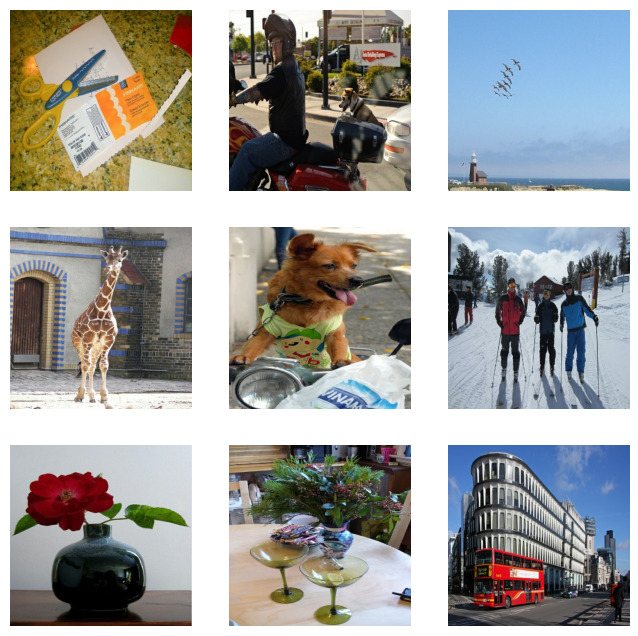

In [5]:
plt.figure(figsize=(8, 8)) # Create drawing figure with size 8x8
for i in range(9): # Loop over each image in the batch
    ax = plt.subplot(3, 3, i+1) # Add subplot to the drawing figure for the image
    plt.imshow(train_set[i]) # Display image using Matplotlib's imshow function
    plt.axis("off") # Turn off image axes
plt.show() # Display the drawing

### 2.6 Création d'images bruitées

Nous avons désormais un dataset réparti et prêt au traitement. Nous allons commencer par bruiter volontairement les photos. 

Le bruit d’une image représente tout parasite ou dégradation que subit l’image lors de son acquisition. On parle de bruit numérique pour désigner l’ensemble des éléments qui peuvent dégrader une image. 

Dans un auto-encodeur de débruitage, on bruite volontairement les images pour créer une imprécision, un défaut à la photo afin que l’algorithme apprenne à rétablir une image sans bruit. Cela permettra de garder uniquement les informations nécessaires pour la suite du traitement et d’enlever tout bruit parasite.

Il existe différents types de bruit, bruit de photon, de lecture, de bande, de grain ou encore de thermoeclectron. Au niveau de ce qu'il se passe numériquement sur les pixels, on peut les résumer en deux principales catégories :
* Un bruit uniforme sur l’ensemble ou une partie des pixels, représenté par une variable finie 
* Un bruit dépendant de la valeur des pixels  

Nous utiliserons une fonction qui ajoutera une valeur aléatoire sur chaque pixel. 

La distribution gaussienne est souvent utilisée pour générer du bruit sur une image car elle est statistiquement similaire au bruit qui peut apparaître naturellement sur une image. Le bruit gaussien ajoute une incertitude à l'image, qui peut être utilisée pour simuler des erreurs de mesure ou des perturbations dans le processus d'acquisition de l'image.

In [6]:
# Define a function that applies Gaussian noise to an image dataset
def apply_gaussian_noise(X, sigma=0.2):
    # Generate noise with mean 0 and standard deviation sigma
    noise = np.random.normal(loc=0.0, scale=sigma, size=X.shape)
    # Add the noise to the image dataset
    X += noise
    # Clipping the value of X between 0 and 1 
    X[X>1] = 1.0
    X[X<0] = 0.0
    # Return the noised dataset
    return X

# Create a copy of the original train and test sets and apply Gaussian noise to them
x_train_noisy = apply_gaussian_noise(train_set.copy())
x_test_noisy = apply_gaussian_noise(test_set.copy())


Nous pouvons afficher les mêmes images une fois le bruit ajouté et visualiser la différence sur la qualité des images.

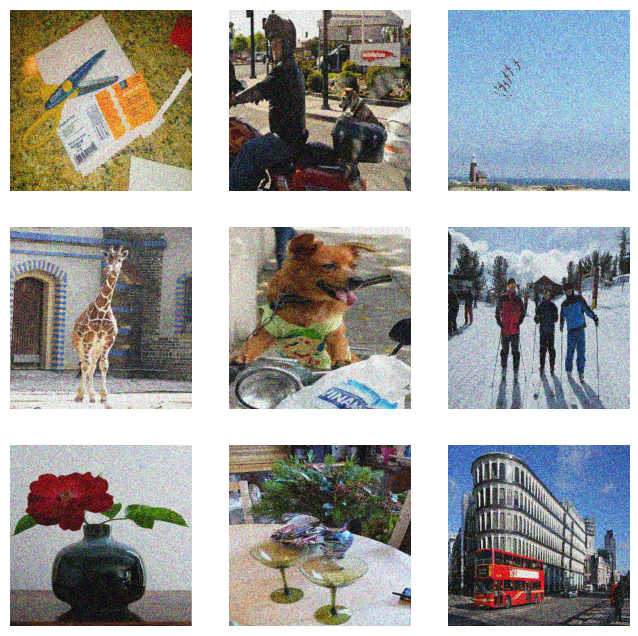

In [7]:
plt.figure(figsize=(8, 8)) # Create drawing figure with size 8x8
for i in range(9): # Loop over each image in the batch
    ax = plt.subplot(3, 3, i+1) # Add subplot to the drawing figure for the image
    plt.imshow(x_train_noisy[i]) # Display image using Matplotlib's imshow function
    plt.axis("off") # Turn off image axes
plt.show() # Display the drawing

Comme nous pouvons le remarquer, les photos sont plus pixélisées. Elles ont perdus de leur vivacité, les couleurs sont saturés. Le bruit a bien été ajouté.

## III. Modélisation d'autoencodeurs pour le débruitage des images

Les auto-encodeurs sont des réseaux de neurones artificiels qui ont été largement utilisés dans le domaine du Deep Learning. Ils ont été initialement introduits dans les années 1980 et ont été utilisés principalement pour la réduction de la dimensionnalité des données. Leur objectif est de créer une représentation de données de dimension réduite qui est tout aussi informative que la représentation d'origine. 


Un auto-encodeur est généralement constitué de deux parties : un encodeur et un décodeur. L'encodeur est utilisé pour encoder les données d'entrée dans une représentation de dimension réduite, tandis que le décodeur est utilisé pour décoder cette représentation de dimension réduite en une reconstruction des données d'entrée. Le modèle est entraîné en utilisant une fonction de perte qui mesure la différence entre les données d'entrée et la reconstruction. L'idée est que, en entraînant le modèle à réduire cette différence, il apprend également à capturer les caractéristiques les plus importantes des données d'entrée. 


Les auto-encodeurs ont été utilisés dans de nombreuses applications, notamment la réduction de la dimensionnalité des données, l'apprentissage non supervisé, la génération de données, la segmentation d'image et la génération d'images. Les auto-encodeurs Variationnel (VAE) et réseaux antagonistes génératifs (GAN) sont devenus populaire dans les dernières années, où l'objectif est de générer des données qui ressemble à celle d'origine. Les auto-encodeurs à Attention (Attention Auto-Encoder) ont été introduits et ils ont démontré de bons résultats dans les tâches de traitement de langue naturelle en permettant de s'attarder sur les parties les plus pertinentes de l'entrée. Les architectures de Transformer ont également été utilisées pour améliorer les résultats des auto-encodeurs. 

Les auto-encodeurs peuvent présenter des défauts tels que :

* la reconstruction de l'entrée peut être imparfaite, surtout pour des données bruyantes ou manquantes.
* les auto-encodeurs peuvent être sujets à l'overfitting, surtout lorsque les données sont limitées.
* Les auto-encodeurs encoderont souvent les features les plus fortes de l'entrée, mais ils peuvent ignorer les features plus subtiles.
* Il peut être difficile de choisir les bonnes fonctions d'encodage et de décodage pour capturer les patterns cachés dans les données.

Il va donc falloir être vigilents à ces défauts pour obtenir de bons résultats, sachant que l'on dispose de 150 fichiers uniquement pour entrainer notre modèle.

### 3.1 Auto-encodeur basique

Nous allons commencer par développer un auto-encodeur basique.

Les auto-encodeurs basique sont des réseaux de neurones traditionnels qui utilisent des couches fully-connected pour encoder et décoder les données. Ils sont généralement utilisés pour les données qui ont une structure linéaire, comme les données tabulaires.

##### 3.1.1 Définition du modèle

Nous définissons dans cette partie les différentes couches du modèle et chaque élément nécessaire.

* On définit les données d'entrée de notre réseau, ici, il s'agira d'images de 384 pixels de large et 384 pixels de haut avec 3 canaux de couleur (RGB).


* La première couche de notre réseau (Flatten) est une étape permettant d'aplatir les données d'entrée en un vecteur 1D. Cela consiste à transformer les données de (384,384,3) en une seule dimension, ce qui va permettre de les traiter en utilisant les couches "fully-connected", ou "pleine". Cette couche est donc composée de 384x384x3 neurones, soit 442368 neurones.


* La deuxième couche de notre réseau (Dense) est une couche dite "fully-connected", ou "pleine", c'est-à-dire que chaque neurone de cette couche est relié à l'ensemble des neurones de la couche précédente. Elle est composée de 256 neurones et utilise fonction d'activation ReLu (Rectified Linear Unit) qui est utilisée pour que les résultats de la couche soient positifs, permettant de traiter les données de manière plus efficace. On procède à une réduction de dimension en réduisant le nombre de neurones par couche.

    - La réduction de dimension est une technique utilisée pour réduire la complexité d'un jeu de données en en réduisant le nombre de dimensions (ou caractéristiques) tout en conservant un maximum d'informations pertinentes.
    

* La troisième couche de notre réseau est également une couche pleine faisant appel à la fonction d'activation ReLu. Cette couche est composé de 64 neurones. Cette couche représentente l'espace latent de notre modèle.

    - Un espace latent est un espace caché utilisé pour représenter les données en réduisant la dimensionnalité et en capturant les principales caractéristiques des données. Il est utilisé dans les modèles d'apprentissage automatique pour améliorer les performances.


* La quatrième et la cinquième couche de notre réseau (Dense) sont des couches pleines avec respectivement 256 et 442368 neurones. Elles utilisent la même fonction d'activation ReLu. Ces couches permettent un processus d'augmentation des données, formalisé par l'augmentation des neurones par couches. Egalement, l'encodeur et le décodeur sont symétrique, d'où le nombre de neurones par couche.


* La dernière couche (Reshape) est utilisée pour redimensionner le vecteur décodé en une forme d'image de (384, 384, 3) afin de correspondre à la forme d'entrée. Cela permet de retrouver la forme d'origine des données.

In [41]:
# Define the input layer of the model with the shape of the input images (384,384,3)
model_input = keras.Input(shape=(384, 384, 3))

# Flatten the input layer
x = layers.Flatten()(model_input)

# Add a dense layer with 256 units and ReLU activation
x = layers.Dense(256, activation='relu')(x)

# Add another dense layer with 64 units, this will be the encoded representation of the input
encoded = layers.Dense(64, activation='relu')(x)

# Add a dense layer with 256 units and ReLU activation
x = layers.Dense(256, activation='relu')(encoded)

# Add a dense layer with 442368 units and ReLU activation
x = layers.Dense(442368, activation='relu')(x)

# Add a reshape layer to reshape the output to the original image shape (384,384,3)
decoded = tf.keras.layers.Reshape(target_shape=(384,384,3))(x)

##### 3.1.2 Compilation du modèle

Dans cette partie nous compilerons le modèle.

Nous faisons appel à l'algorithme d'optimisation ADAM, un optimiseur d'apprentissage automatique qui adapte les taux d'apprentissage pour chaque paramètre en utilisant des mécanismes d'estimation des moyennes et des variances mobiles exponentielles. Il est souvent utilisé pour des modèles de réseaux de neurones profonds et connu pour sa vitesse de convergence vers une solution optimale.

Nous utilisons la fonction de perte "MeanSquaredError". Elle mesure la différence entre les prédictions du modèle et les valeurs cibles. Plus précisément, elle calcule la moyenne des erreurs au carré entre les prédictions du modèle et les valeurs cibles pour chaque élément d'entrée. En utilisant cette fonction de perte, le modèle apprend à minimiser la moyenne des erreurs au carré entre ses prédictions et les valeurs cibles, ce qui le rend efficace pour les tâches de prédiction de valeurs continues telles que la prédiction de prix de vente de maisons ou la prédiction de températures.

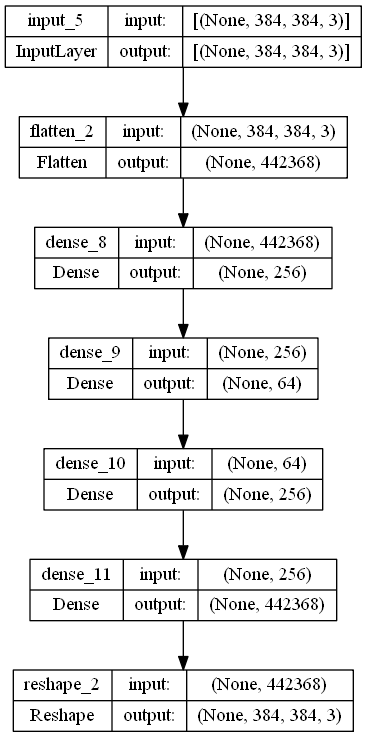

In [42]:
# Create the autoencoder model
autoencoder = keras.Model(model_input, decoded)

# Compile the model
autoencoder.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError())

# Plot the model architecture
plot_model(autoencoder, show_shapes=True)

##### 3.1.3 Entrainement du modèle

Ce code permet d'entrainer le modèle sur notre jeu de données d'entrainement, et de faire le processus de validation pour connaitre la performance du modèle sur des données qu'il ne connait pas.

Le modèle prend en entrée une image bruitée, puis vérifie sa prédiction avec l'image originale non bruitée. Il calcule l'erreur avec la fonction de perte, et ajuste ses poids.

In [44]:
# Set the number of epochs to train for
epochs = 100

# Create a callback for early stopping with a patience of 8
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# Train the autoencoder using the noisy training data, original training data as target, 
# batch size of 10, validation data as the noisy test data and original test data, 
# for a total of 100 epochs, with shuffling of the data after each epoch, and using the early stopping callback
history = autoencoder.fit(
    x_train_noisy,train_set, batch_size=10, validation_data=(x_test_noisy,test_set), epochs=epochs, shuffle=True, callbacks=[callback]
)



Epoch 1/100
12/12 [==============================] - 1s 78ms/step - loss: 0.2361 - val_loss: 0.2165
Epoch 2/100
12/12 [==============================] - 1s 72ms/step - loss: 0.2351 - val_loss: 0.2160
Epoch 3/100
12/12 [==============================] - 1s 73ms/step - loss: 0.2344 - val_loss: 0.2165
Epoch 4/100
12/12 [==============================] - 1s 71ms/step - loss: 0.2342 - val_loss: 0.2153
Epoch 5/100
12/12 [==============================] - 1s 69ms/step - loss: 0.2337 - val_loss: 0.2149
Epoch 6/100
12/12 [==============================] - 1s 70ms/step - loss: 0.2332 - val_loss: 0.2151
Epoch 7/100
12/12 [==============================] - 1s 72ms/step - loss: 0.2336 - val_loss: 0.2161
Epoch 8/100
12/12 [==============================] - 1s 71ms/step - loss: 0.2335 - val_loss: 0.2147
Epoch 9/100
12/12 [==============================] - 1s 71ms/step - loss: 0.2330 - val_loss: 0.2140
Epoch 10/100
12/12 [==============================] - 1s 69ms/step - loss: 0.2323 - val_loss: 0.2139

##### 3.1.4 Résultat du modèle

Maintenant que le modèle est entrainné, nous allons afficher ses statistiques d'entrainemment. Dans se cas nous allons afficher sa fonction de perte (la MSE) afin d'avoir une idée des résultats de notre modèle.

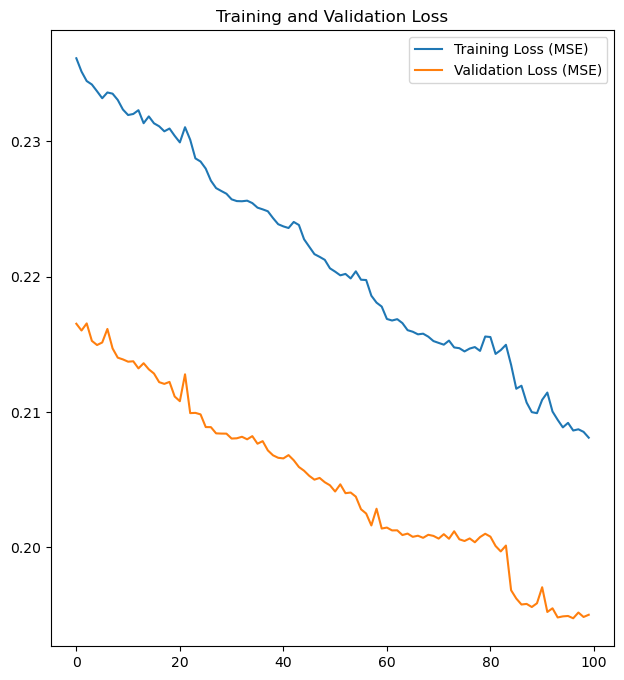

In [45]:
# Retrieve training and validation accuracy and loss history
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(loss)) # Generate range of epochs
plt.figure(figsize=(16, 8)) # Create figure with subplots

# Add second subplot showing training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss (MSE)')
plt.plot(epochs_range, val_loss, label='Validation Loss (MSE)')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Comme nous pouvons le constater sur les courbes, la fonction de perte (ici Mean Squared Error) se stabilise autour 0.257. Cela signifie que pour chaque valeur RGB de chaque pixel, il y a en moyenne 0.17 d'erreur par rapport à la valeur attendue. Pour des valeurs comprises entre 0 et 1, une MSE de 0.17 semble très élevée, d'autant plus que chaque pixel est défini par 3 valeurs, aggravant donc les erreurs sur l'image de sortie. Afin de nous assurer de ces résultats, nous allons afficher les images sortant du modèle à partir de plusieurs images de notre jeu de données d'entrainement.

1/1 [==============================] - 0s 64ms/step


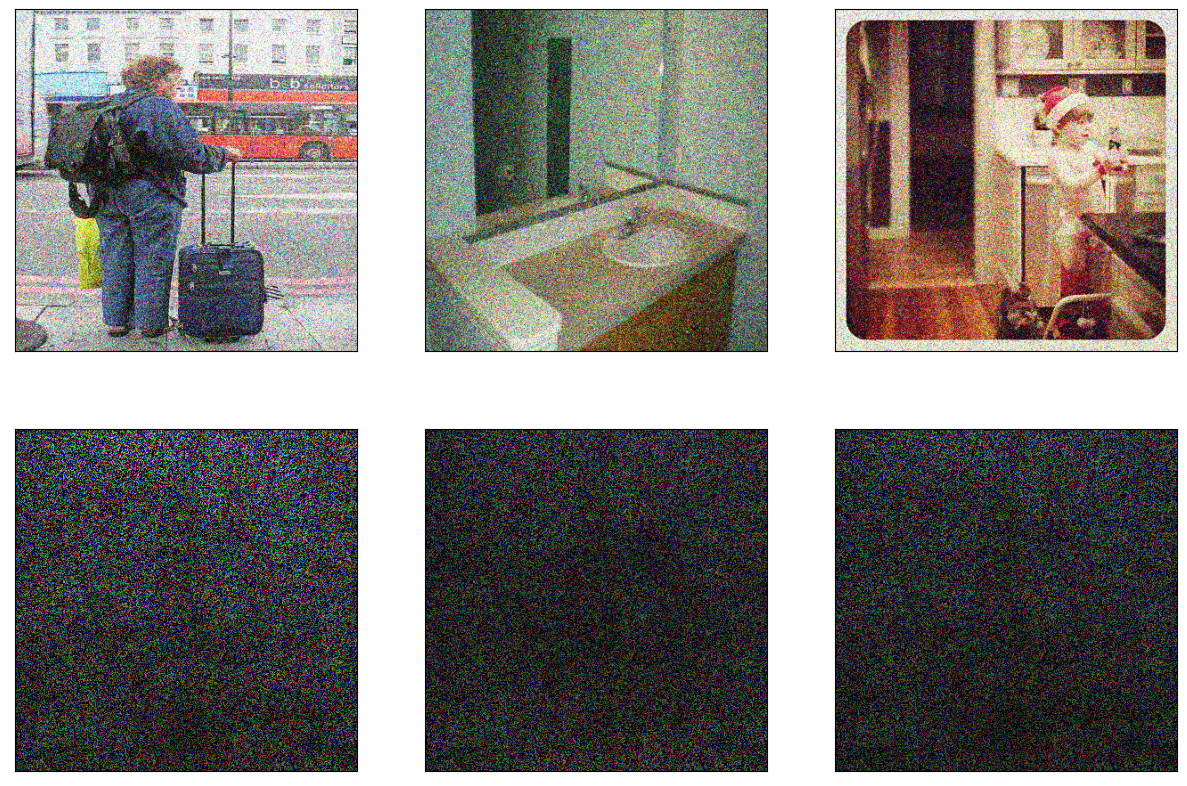

In [46]:
# Specify the number of test images to display
n = 3

# Create a figure with size 15x10 inches
plt.figure(figsize=(15, 10))

# Use the autoencoder to predict the output of the test set (for n elements)
predictions = autoencoder.predict(x_test_noisy[:n])

# Plot the original and reconstructed images
for i in range(n):
    # Original images
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test_noisy[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Reconstructed images
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(predictions[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

# Show the plot
plt.show()

Comme nous l'attendions, les images qui sortent du modèle sont de très mauvaise qualité. Les différents éléments des photographies ne sont plus reconnaissables, bien qu'on peut voir certaines formes se dessiner. D'après nous cette forte imprécision est due au fait que les images passent de 442 000 caractéristiques  (image de 384x384x3) à 216 avec la couche dense. Cette forte réduction du nombre de dimensions entraine selon nous une trop grosse perte d'informations sur les images. Cela ne permet pas de reconstruire les images efficacement. Malheureusement, nous ne pouvons pas augmenter le nombre de neurones sur les couches cachées, car nous ne disposons pas d'assez de mémoire pour entrainer le modèle (Out Of Memory). Par conséquent, nous avons décidé de passer à un autre style d'auto-encodeur afin d'obtenir de meilleurs résultats : les auto-encodeurs convolutifs.

### 3.2 Auto-encodeur convolutif

Pour obtenir de meilleur résultat, nous allons passer sur un auto-encodeur convolutif.

Un auto-encodeur convolutif est un réseau de neurones qui utilise des couches de convolution pour extraire des caractéristiques à partir d'images ou de signaux. Il est utilisé pour la compression d'images ou la génération d'images.

##### 3.2.1 Définition du modèle

Nous définissons dans cette partie les différentes couches du modèle et chaque élément nécessaire.

On peut retrouver les différentes couches :

* On définit les données d'entrées de notre réseau, ici, il s'agira d'images de 384 pixels de large et 384 pixels de haut avec 3 canaux de couleur (RGB)


* Les lignes suivantes utilisent des couches de convolution, des couches de MaxPooling et des couches d'UpSampling pour encoder et décoder l'image.

  * Les couches de convolution (layers.Conv2D) utilisent des filtres pour extraire des caractéristiques de l'image. Ici, il y a 3 couches de convolution, chacune avec un nombre croissant de filtres passant de 16 à 64 à 256 au niveau de l'espace latent. Cela permet de préciser les caractéristiques de l'image et d'être plus précis sur la détection. Afin de conserver la symétrie du modèle, 2 autres couches de convolutions avec dees filtres de 64 puis 16 sont ajoutées à la suite de l'espace latent. Cette étape permet de diversifier les caractéristiques des images.
  
  * Les couches de MaxPooling (layers.MaxPooling2D) utilisent un pooling pour réduire la dimension de l'image. Ici, le pooling est appliqué après chaque couche de convolution pour réduire la taille de l'image de moitié à chaque fois.
  
  * Les couches d'UpSampling (layers.UpSampling2D) augmentent la taille de l'image pour la récupérer à sa taille d'origine.
  
  
* La dernière couche de convolution correspond à la dernière version décodée de l'image. Cette couche comprend 3 caractéristiques, correspondant aux 3 canaux RGB, comme dans la couche Input.


In [30]:
# Define the input layer for the model
model_input = keras.Input(shape=(384, 384, 3))
# Add a convolutional layer with 16 filters, kernel size 3x3, and 'same' padding
x = layers.Conv2D(16, 3, padding='same')(model_input)
# Add a max pooling layer
x = layers.MaxPooling2D()(x)
# Add a convolutional layer with 64 filters, kernel size 3x3, and 'same' padding
x = layers.Conv2D(64, 3, padding='same')(x)
# Add a max pooling layer
x = layers.MaxPooling2D()(x)
# Add a convolutional layer with 256 filters, kernel size 3x3, 'same' padding and ReLU activation
encoded = layers.Conv2D(256, 3, activation='relu', padding='same')(x)

# Add a convolutional layer with 64 filters, kernel size 3x3, and 'same' padding
x = layers.Conv2D(64, 3, padding='same')(encoded)
# Add an UpSampling2D layer
x = layers.UpSampling2D()(x)
# Add a convolutional layer with 16 filters, kernel size 3x3, and 'same' padding
x = layers.Conv2D(16, 3, padding='same')(x)
# Add an UpSampling2D layer
x = layers.UpSampling2D()(x)
# Add a convolutional layer with 3 filters, kernel size 3x3, and 'same' padding
decoded = layers.Conv2D(3, 3, padding='same')(x)


##### 3.2.2 Compilation du modèle

Ce code permet de compiler notre modèle avec l'algorithme d'optimisation, la fonction de perte. 

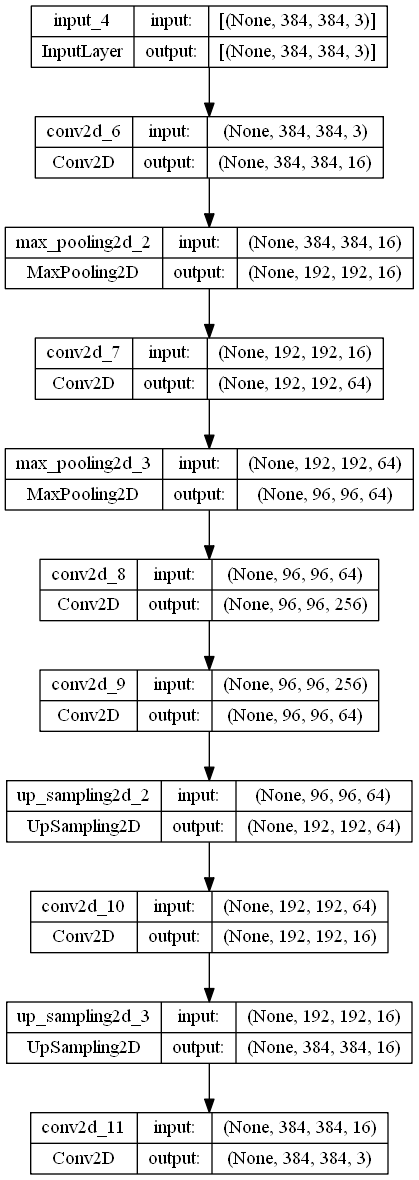

In [31]:
# Create the autoencoder model
autoencoder = keras.Model(model_input, decoded)

# Compile the model
autoencoder.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError())

# Plot the model architecture
plot_model(autoencoder, show_shapes=True)


##### 3.2.3 Entraînement du modèle

Ce code permet d'entrainer le modèle sur notre jeu de données d'entrainement, et de faire le processus de validation pour connaitre la performance du modèle sur des données qu'il ne connait pas.

Le modèle prend en entrée une image bruitée, puis vérifie sa prédiction avec l'image originale non bruitée. Il calcule l'erreur avec la fonction de perte, et ajuste ses poids.

In [32]:
# Set the number of epochs to train for
epochs = 100

# Create a callback for early stopping with a patience of 5
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# Train the autoencoder using the noisy training data, original training data as target, 
# batch size of 10, validation data as the noisy test data and original test data, 
# for a total of 100 epochs, with shuffling of the data after each epoch, and using the early stopping callback
history = autoencoder.fit(
    x_train_noisy,train_set, batch_size=10, validation_data=(x_test_noisy,test_set), epochs=epochs, shuffle=True, callbacks=[callback]
)


Epoch 1/100
12/12 [==============================] - 2s 122ms/step - loss: 0.2565 - val_loss: 0.0214
Epoch 2/100
12/12 [==============================] - 1s 119ms/step - loss: 0.0254 - val_loss: 0.0120
Epoch 3/100
12/12 [==============================] - 1s 124ms/step - loss: 0.0136 - val_loss: 0.0091
Epoch 4/100
12/12 [==============================] - 1s 125ms/step - loss: 0.0103 - val_loss: 0.0073
Epoch 5/100
12/12 [==============================] - 1s 124ms/step - loss: 0.0084 - val_loss: 0.0060
Epoch 6/100
12/12 [==============================] - 1s 122ms/step - loss: 0.0074 - val_loss: 0.0053
Epoch 7/100
12/12 [==============================] - 1s 123ms/step - loss: 0.0068 - val_loss: 0.0049
Epoch 8/100
12/12 [==============================] - 2s 160ms/step - loss: 0.0062 - val_loss: 0.0047
Epoch 9/100
12/12 [==============================] - 2s 144ms/step - loss: 0.0060 - val_loss: 0.0045
Epoch 10/100
12/12 [==============================] - 2s 151ms/step - loss: 0.0058 - val_lo

##### 3.2.4 Résultat du modèle

Maintenant que le modèle est entrainé, nous allons afficher ses statistiques d'entrainemment. Dans ce cas, nous allons afficher sa fonction de perte (la MSE) afin d'avoir une idée des résultats de notre modèle.

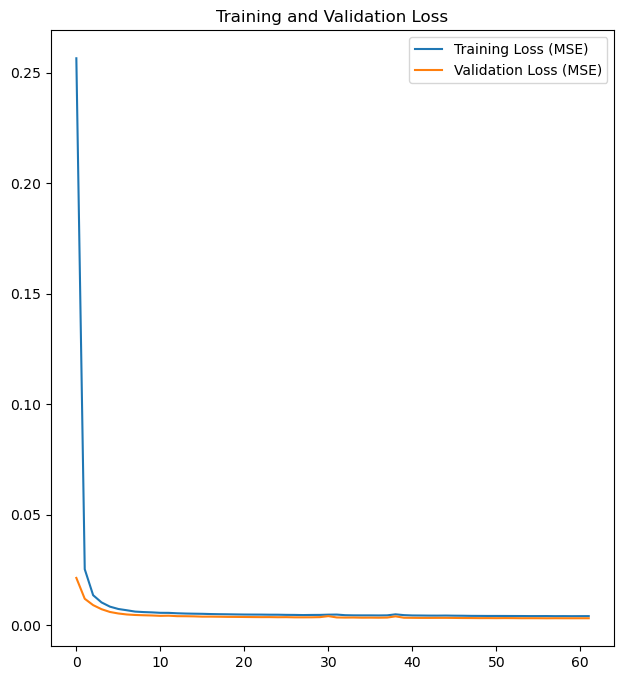

In [33]:
# Retrieve training and validation accuracy and loss history
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(loss)) # Generate range of epochs
plt.figure(figsize=(16, 8)) # Create figure with subplots

# Add second subplot showing training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss (MSE)')
plt.plot(epochs_range, val_loss, label='Validation Loss (MSE)')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Comme nous pouvons le constater sur les courbes, la fonction de perte (ici Mean Squared Error) se stabilise autour 0.0041. Cela signifie que pour chaque valeur RGB de chaque pixel il y a en moyenne 0.0041 d'erreur par rapport à la valeur attendue. Pour des valeurs comprises entre 0 et 1, une MSE de 0.0041 semble plutôt correcte. 

#### 3.2.5 Etude de cas

Afin de nous assurer de ces résultats, nous allons afficher les images sortant du modèle à partir de plusieurs images de notre jeu de données d'entrainement. Nous allons effectuer une étude de cas pour déceler les forces et faiblesses dans ces résultats.

1/1 [==============================] - 0s 24ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


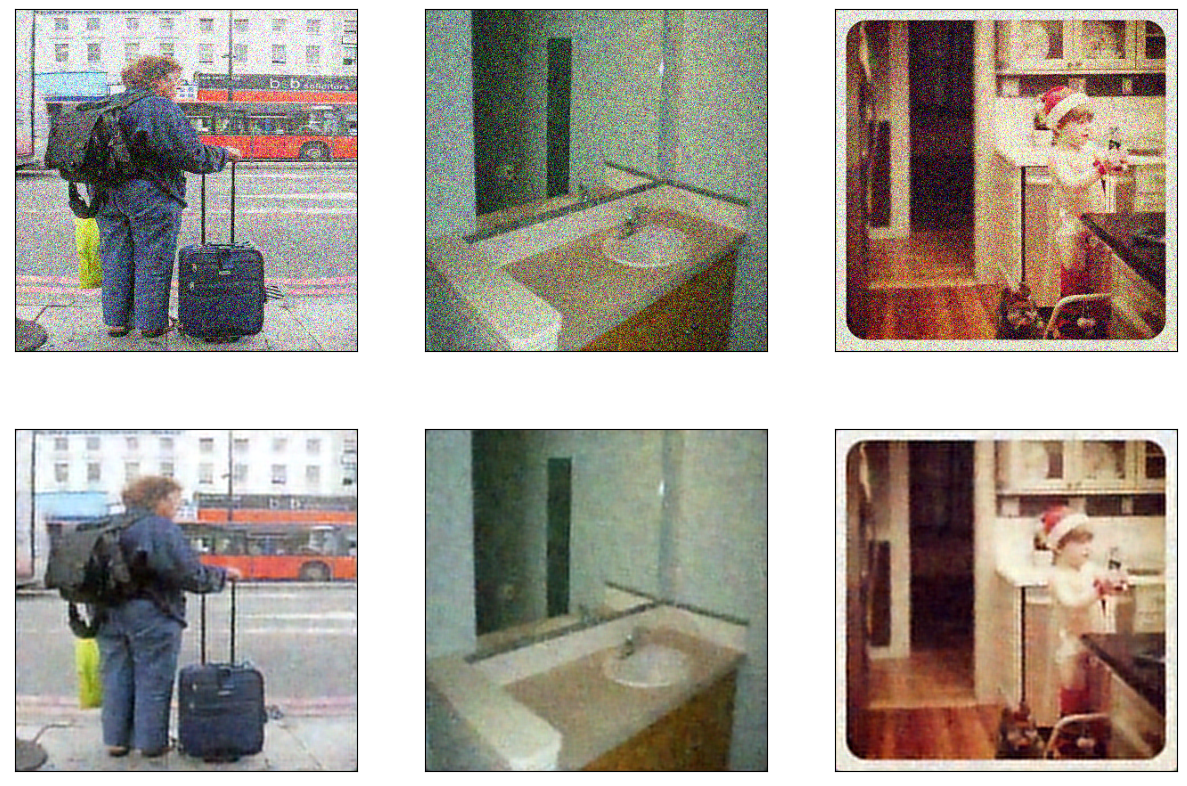

In [39]:
# Set the number of images to display
n = 3

# Create a figure with size 15x10 inches
plt.figure(figsize=(15, 10))

# Use the trained autoencoder model to make predictions on the first n images of the noisy test data
predictions = autoencoder.predict(x_test_noisy[:n])

# Iterate through the first n images
for i in range(n):

    # Create a subplot for the current image
    ax = plt.subplot(2, n, i + 1)
    # Display the noisy image
    plt.imshow(x_test_noisy[i])
    # Hide the x and y axis
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Create a subplot for the corresponding prediction
    ax = plt.subplot(2, n, i + 1 + n)
    # Display the prediction
    plt.imshow(predictions[i])
    # Hide the x and y axis
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

# Show the figure
plt.show()


Cette fois-ci les images sont bien plus qualitatives ! Les différents éléments des photographies sont clairement identifiables et reconnaissables, bien que les images soient légerement floues et encore un peu bruitée. Le flou généré est normal pour ce type de traitement. Des résidus de bruits peuvent cependant être décelés principalement sur les photos claires. 



#### 3.2.6 Essais d'architectures

Le modèle ci-dessus est le meilleur que nous ayons obtenu après de nombreux essais avec des architectures différentes et / ou des paramètres différents. On peut voir ci-dessous tous les modèles qui ont été testés avec leurs résultats.



A noter que le modèle que nous entendons par "Auto-encodeur convolutif de base" est le suivant :

```py
model_input = keras.Input(shape=(384, 384, 3))
x = layers.Conv2D(16, 3, padding='same')(model_input)
x = layers.MaxPooling2D((2,2))(x)
x = layers.Conv2D(64, 3, padding='same')(x)
x = layers.MaxPooling2D((2,2))(x)
encoded = layers.Conv2D(256, 3, padding='same')(x)

x = layers.Conv2D(64, 3, padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(16, 3, padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(3, 3, padding='same')(x)```


| Nom | Epochs | MSE (Train) | MSE (Test) | Commentaires |
| :------- |:---------------:|:-----:|:---------:|:-------:|
|Auto-encodeur de base (cf. 3.1.1) |32 (1s)|0,2340|0,2137|Les images ne sont pas débruitées + les images ne sont pas reconnaissables|
|Auto-encodeur convolutif de base  + batch_size = 1|11 (1s)|0,0058|0,0042|Les images sont partiellement débruitées + léger flou + très légère perte de luminosité|
|Auto-encodeur convolutif de base + batch_size = 10|27 (1s)|0,0045|0,0036|Les images sont partiellement débruitées + léger flou|
|Auto-encodeur convolutif de base + batch_size = 20|57 (1s)|0,0045|0,0036|Les images sont partiellement débruitées + léger flou|
|Auto-encodeur convolutif de base + division des filtres par 2 + batch_size = 10|56 (1s)|0,0057|0,0044|Les images sont partiellement débruitées + léger flou|
|Auto-encodeur convolutif de base + multiplication des filtres par 2 + batch_size = 10|54 (3s)|0,0063|0,0051|Les images sont partiellement débruitées + léger flou|
|Auto-encodeur convolutif de base + couche de convolution supplémentaire à 128 filtres + batch_size = 10|57 (1s)|0,0099|0,0079|Les images sont partiellement débruitées +  flou très important + perte de couleur|
|Auto-encodeur convolutif de base + pool_size = (4,4) + batch_size = 10|94 (1s)|0,0124|0,0094|Les images sont partiellement débruitées +  flou très important + perte de couleur|
|Auto-encodeur convolutif de base + activation = 'relu' + batch_size = 10|42 (1s)|0,0049|0,0038|Les images sont globalement débruitées + léger flou|
|Auto-encodeur convolutif de base + activation = 'tanh' + batch_size = 10|48 (1s)|0,0056|0,0044|Les images sont partiellement débruitées + léger flou + image blanchâtre|
|Auto-encodeur convolutif de base + activation = 'relu' et 'sigmoid' (fin) + batch_size = 10|42 (1s)|0,0050|0,0038|Les images sont partiellement débruitées + léger flou|
|Auto-encodeur convolutif de base + activation = 'relu' (milieu) et 'tanh' (fin) + batch_size = 10|68 (1s)|0,0042|0,0034|Les images sont partiellement débruitées + léger flou|
|Auto-encodeur convolutif de base + activation = 'relu' (milieu) + batch_size = 10|88(1s)|0,0041|0,0030|Les images sont partiellement débruitées + léger flou

## IV. Résultats et conclusion

En conclusion, nous avons testé de nombreux modèles différents. Tout d'abord, un auto-encodeur basique, sans convolution, puis nous avons créé un modèle convolutif simple. Nous avons ensuite essayé de nombreuses architectures et paramètres différents pour obtenir les meilleurs résultats possibles à partir de l'auto-encodeur convolutif. Une fois que nous n'arrivions plus à améliorer les résultats, nous avons choisi le modèle qui donnait, selon nous les meilleures images en sorties (Modèle qu'on peut voir plus haut dans le notebook). Bien que les images soient légèrement floues et encore un peu bruitées, elles restent largement reconnaissables en vue de la prochaine étape de ce projet.